In [52]:
import os
import datetime
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from enum import Enum

mpl.rcParams['figure.figsize'] = (25,8)
mpl.rcParams['axes.grid'] = False

### Features:


In [53]:
DO_NOT_USE_EARLY_STOPPING = True
DROP_INDEX_LIKE_COLUMNS = True
LABEL_WIDTH_EQ_SHIFT = True
WINDOW_WIDTH = 3
LABEL_WIDTH = 1
SHIFT = 1

In [54]:
USED_STORE_ID = 4051653300272
FEATURE_SIZE = 87
DATA_ORIGIN = "./merged_cleaned_FE_imputed(v)_w.csv"
DROPPED_COLUMNS = [
    "WeekoftheYear_cos",
    "WeekoftheYear_sin",
    "DayoftheYear_cos",
    "DayoftheYear_sin",
    "Month_cos",
    "Month_sin",
    "Season_Autumn",
    "Season_Spring",
    "Season_Summer",
    "Season_Winter",
]

class PRODUCT_IDs(Enum):
    BensLunchtime = "4260705920294"

In [55]:
def load_data():
    df = pd.read_csv(DATA_ORIGIN, parse_dates=["Date"])
    not_indexed = ["ProductID", "Quantity", "Price_imputed", "Year"]
    df_pivot = df.pivot_table(
        index=[col for col in list(df.columns) if col not in not_indexed],
        columns=["ProductID"],
        values="Quantity",
    )
    df_pivot["total_quantity_day"] = df_pivot.sum(axis=1)

    df_pivot = df_pivot.loc[df_pivot.index.get_level_values("StoreID") == USED_STORE_ID]
    df_pivot = df_pivot.droplevel("StoreID")
    df_pivot = df_pivot.reset_index()
    df_pivot.columns = df_pivot.columns.astype(str)

    return df_pivot


def add_fourier_features(
    data,
    features_to_period={
        "Month": 12.0,
        "DayoftheMonth": 31.0,
        "WeekoftheMonth": 4.0,
        "DayoftheWeek": 7.0,
        "WeekoftheYear": 52.0,
        "DayoftheYear": 365.0,
    },
):
    df = data.copy()

    for column, period in features_to_period.items():
        df[f"{column}_cos"] = np.cos(2 * np.pi * df["Month"] / period)
        df[f"{column}_sin"] = np.sin(2 * np.pi * df["Month"] / period)

    return df.drop(
        features_to_period.keys(),
        axis=1,
    )


def get_dataset():
    df_pivot = load_data()
    date_time = pd.to_datetime(df_pivot.pop("Date"), format="%Y-%m-%d")
    data = add_fourier_features(df_pivot)
    return data, date_time


def split_data(data, train_frac=0.7, valid_frac=0.2, test_frac=0.1):
    if not math.isclose(train_frac + valid_frac + test_frac, 1):
        raise Error("Ivalid split sizes")

    n = len(data)
    train_df = data[0 : int(n * train_frac)]
    val_df = data[int(n * train_frac) : int(n * (train_frac + valid_frac))]
    test_df = data[int(n * (train_frac + valid_frac)) :]

    return train_df, val_df, test_df


def normalize(data, norm_values_to_use=None):
    norm_values_used = norm_values_to_use
    if norm_values_to_use is None:
        std = data.std()
        std = std.where(lambda x: np.invert(np.isclose(x, 0)), other=0.3)
        norm_values_used = {
            "std": std,
            "mean": data.mean(),
        }

    return (data - norm_values_used["mean"]) / (
        norm_values_used["std"]
    ), norm_values_used

In [56]:
data, time = get_dataset()
if DROP_INDEX_LIKE_COLUMNS:
    data = data.drop(
        labels=DROPPED_COLUMNS,
        axis="columns",
    )
train_df, val_df, test_df = split_data(data)

train_df, normalization_params = normalize(train_df)
val_df, _ = normalize(val_df, normalization_params)
test_df, _ = normalize(test_df, normalization_params)
assert FEATURE_SIZE == len(train_df.columns)

In [57]:
# Code reference: https://github.com/anencore94/SlidingWindowGenerator/blob/master/slidingwindow_generator/slidingwindow_generator.py
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, val_df, test_df,
                label_columns=None):
        '''
        This drawing indicates the meaning of the attributes:

        ------------------------Time Dimension ----------------->
                                               |
        <----------total window size---------->|
        <------input width------><---shift---->|
                    <------label width-------->|
                                               |

        '''
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        '''
        splits the incoming data: (batch_size, total_window_size, all_features)
        into:
        inputs: (batch_size, input_width, all_features)
        labels: (batch_size, label_width, #label_columns)

        while the timesteps are according to the parameter meaning (see description of class)
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col=PRODUCT_IDs.BensLunchtime.value, max_subplots=3, used_normalization=None):
        def denormalize(data):
            if used_normalization is None:
                return data
            return data * used_normalization['std'][plot_col] + used_normalization['mean'][plot_col]

        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, denormalize(inputs[n, :, plot_col_index]),
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, denormalize(labels[n, :, label_col_index]),
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, denormalize(predictions[n, :, label_col_index]),
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [day]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

-----
# General Settings

In [58]:
## For tracking Model Performances:
val_performance = {}
performance = {}
train_performance = {}
test_performance = {}


In [59]:
def get_loss():
    ## !!! change function save_performance when changing here
    return tf.keras.losses.MeanSquaredError()


def get_metrics():
    ## !!! change function save_performance when changing here
    return [tf.keras.metrics.MeanAbsoluteError()]


def save_performance(where):
    df = pd.DataFrame(columns=["Instances_Train", "Loss_Train", "MAE_Train", "Latency_Train", "Trainable_Parameters", "Non_Trainable_Parameters",
                               "Instances_Val", "Loss_Val", "MAE_Val", "Latency_Val",
                               "Instances_Test", "Loss_Test", "MAE_Test", "Latency_Test"])

    for model_name in train_performance.keys():
        df.loc[model_name] = train_performance[model_name] + val_performance[model_name] + test_performance[model_name]

    df.to_csv(where)

def get_model_size(model):
    import os
    import tempfile

    _, keras_file = tempfile.mkstemp('.h5')
    tf.keras.models.save_model(model, keras_file, include_optimizer=False)
    print(f"Model size: {os.path.getsize(keras_file) / 1024 / 1024} MB")

def register_performance(name, model, window):
    import time
    n_train = window.train_df.shape[0]
    n_val = window.val_df.shape[0]
    n_test = window.test_df.shape[0]

    start_time = time.time()
    train_performance[name] = model.evaluate(window.train, verbose=0)
    train_time = time.time() - start_time

    start_time = time.time()
    val_performance[name] = model.evaluate(window.val, verbose=0)
    val_time = time.time() - start_time

    start_time = time.time()
    test_performance[name] = model.evaluate(window.test, verbose=0)
    test_time = time.time() - start_time

    performance = {
        "n_train": n_train,
        "n_val": n_val,
        "n_test": n_test,
        "train_loss": train_performance[name][0],
        "train_mae": train_performance[name][1],
        "val_loss": val_performance[name][0],
        "val_mae": val_performance[name][1],
        "test_loss": test_performance[name][0],
        "test_mae": test_performance[name][1],
        "train_latency": train_time / n_train,
        "val_latency": val_time / n_val,
        "test_latency": test_time / n_test,
        "network_size_MB": get_model_size(model),
        "n_trainable_params": np.sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
        "n_non_trainable_params": np.sum([tf.size(w_matrix).numpy() for w_matrix in model.non_trainable_variables])
    }
    return performance

---

## Single Step Models

In [60]:
single_step_window = WindowGenerator(
    input_width=WINDOW_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    label_columns=[PRODUCT_IDs.BensLunchtime.value],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
)
single_step_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['4260705920294']

In [61]:
MAX_EPOCHS = 50


def compile_and_fit(model, window, patience=2):
    if not DO_NOT_USE_EARLY_STOPPING:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=patience, mode="min"
        )

    model.compile(
        loss=get_loss(), optimizer=tf.keras.optimizers.Adam(), metrics=get_metrics()
    )

    callbacks = [early_stopping if not DO_NOT_USE_EARLY_STOPPING else None]

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[func for func in callbacks if func is not None],
    )
    return history

## Dense Model

In [62]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(WINDOW_WIDTH, FEATURE_SIZE)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=LABEL_WIDTH),
    tf.keras.layers.Reshape(target_shape=(LABEL_WIDTH, 1))
])
print(dense.summary())

history = compile_and_fit(dense, single_step_window)

register_performance('Dense', dense, single_step_window)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 261)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                16768     
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
 reshape_7 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
6/6 [=============================

{'n_train': 190,
 'n_val': 54,
 'n_test': 28,
 'train_loss': 8.68667266331613e-05,
 'train_mae': 0.002683955477550626,
 'val_loss': 1.4895983934402466,
 'val_mae': 0.9683351516723633,
 'test_loss': 2.5901131629943848,
 'test_mae': 1.3686670064926147,
 'train_latency': 0.0007835890117444491,
 'val_latency': 0.0029895835452609593,
 'test_latency': 0.004357576370239258,
 'network_size_MB': None,
 'n_trainable_params': 20993,
 'n_non_trainable_params': 0.0}

In [63]:
performance_metrics = register_performance('Dense', dense, single_step_window)

Model size: 0.0982513427734375 MB


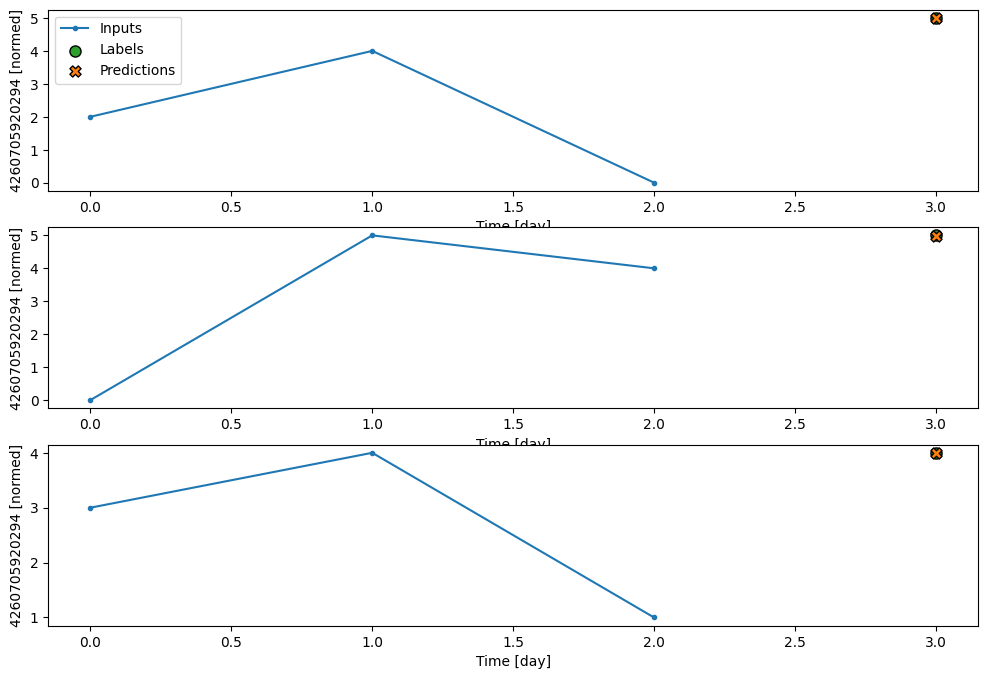

In [64]:
single_step_window.plot(dense, used_normalization=normalization_params)